### GOES HRC proxy:

``HRC_PROXY = 6000 x P4 + 270000 x P5 + 100000 x P6``

where P4, P5 and P6 are corresponding proton channels from

(the most recent two hours)<br>
``https://services.swpc.noaa.gov/text/goes-energetic-proton-flux-primary.txt``

or

(archival data since May 2015)<br>
``ftp://ftp.swpc.noaa.gov/pub/lists/pchan/``

__Old channels:__

Label: P1 = Protons from 0.7 -   4 MeV units #/cm2-s-sr-MeV<br>
Label: P2 = Protons from   4 -   9 MeV units #/cm2-s-sr-MeV<br>
Label: P3 = Protons from   9 -  15 MeV units #/cm2-s-sr-MeV<br>
Label: P4 = Protons from  15 -  40 MeV units #/cm2-s-sr-MeV<br>
Label: P5 = Protons from  38 -  82 MeV units #/cm2-s-sr-MeV<br>
Label: P6 = Protons from  84 - 200 MeV units #/cm2-s-sr-MeV<br>
Label: P7 = Protons from 110 - 900 MeV units #/cm2-s-sr-MeV<br>
Label: P8 = Protons from 350 - 420 MeV units #/cm2-s-sr-MeV<br>
Label: P9 = Protons from 420 - 510 MeV units #/cm2-s-sr-MeV<br>
Label: P10= Protons from 510 - 700 MeV units #/cm2-s-sr-MeV<br>
Label: P11= Protons from      >700 MeV units #/cm2-s-sr-MeV<br>

__GOES-16__ data can be found at ``https://services.swpc.noaa.gov/json/goes/primary/``

__NOTE:__ GOES-16 proton differential flux units are ``per keV`` and not ``per MeV`` as for the earlier GOES satellites.

__NOTE:__ Run this notebook in a custom ``ska`` environment to be able to manipulate the .nc files:

``> alias skax 'unsetenv PERL5LIB; source /proj/sot/ska3/mta/bin/ska_envs.csh; set prompt="skax-$prompt:q"'``<br>
``> skax``<br>

In [1]:
%matplotlib inline
import json
import requests
import os
from ftplib import FTP
import numpy as np
import matplotlib.pyplot as plt
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime
from Ska.engarchive import fetch as fetch
from astropy.table import Table
from astropy.io import ascii

In [2]:
def calc_hrc_proxy(p4, p5, p6):
    return 6000 * p4 + 270000 * p5 + 100000 * p6

def add_date_column(tab):
    hhmm = [f"{t['HHMM']:04d}" for t in tab]
    dates = []
    for row in tab:
        hhmm = f"{row['HHMM']:04d}"
        date = f"{row['YR']}-{row['MO']:02d}-{row['DA']:02d}T{hhmm[:2]}:{hhmm[2:]}:00.000"
        dates.append(date)        
    tab['date'] = dates

def extract_p4_p5_p6_hrc_proxy(fname):
    protons = Table.read(fname, format='ascii', names=NAMES)
    hrc_proxy = calc_hrc_proxy(protons['P4'], protons['P5'], protons['P6'])
    protons['hrc_proxy'] = hrc_proxy
    return protons

def plot_hrc_proxy(tab, label='', color='C0'):
    times = DateTime(tab['date']).secs
    plot_cxctime(times, tab['hrc_proxy'] / 256, label=label, color=color)
    plt.title('GOES HRC proxy / 256')
    plt.ylim(1, 30)
    
def plot_p4_p5_p6(fnames, protons):

    colors = []
    for i in range(len(protons)):
        colors.append(f'C{i}')
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    for f, p, c in zip(fnames, protons, colors):
        plt.plot(p['P4'], color=c, alpha=0.7, label=f[:8])
    plt.legend()
    plt.title('P4')
    plt.yscale('log')
    plt.ylim(2e-4, 5e-2)
    plt.grid()

    plt.subplot(1, 3, 2)
    for f, p, c in zip(fnames, protons, colors):
        plt.plot(p['P5'], color=c, alpha=0.7, label=f[:8])
    plt.legend()
    plt.title('P5')
    plt.yscale('log')
    plt.ylim(2e-4, 5e-2)
    plt.grid()

    plt.subplot(1, 3, 3)
    for f, p, c in zip(fnames, protons, colors):
        plt.plot(p['P6'], color=c, alpha=0.7, label=f[:8])
    plt.legend()
    plt.title('P6')
    plt.yscale('log')
    plt.ylim(2e-4, 5e-2)
    plt.grid()
    
def plot_hrc_shield(times, vals, marker=None, linestyle='solid'):
    secs = times
    hrc_shield = vals / 256.
    bad = hrc_shield < 0.1
    hrc_shield = hrc_shield[~bad]
    secs = secs[~bad]

    plt.figure(1, figsize=(6, 4))
    ticks, fig, ax = plot_cxctime(secs, hrc_shield, marker=marker, linestyle=linestyle)
    xlims = ax.get_xlim()
    dx = (xlims[1] - xlims[0]) / 20.
    ax.set_xlim(xlims[0] - dx, xlims[1] + dx)
    ax.set_ylim(min(hrc_shield.min() * 0.5, 10.0),
                max(hrc_shield.max() * 2, 300.))
    plt.plot([xlims[0] - dx, xlims[1] + dx], [235, 235], '--r')
    ax.set_yscale('log')
    plt.grid()
    plt.title('GOES proxy for HRC shield rate / 256')
    plt.ylabel('Cts / sample')
    plt.tight_layout()    

In [3]:
NAMES = ['YR', 'MO', 'DA', 'HHMM', 'Day1', 'Day2', 'P1', 'P2', 'P3',
         'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11']

## Archival GOES data (2015-2020)

In [4]:
"""
date1 = '2015-05-30T00:00:00.00'
date2 = '2020-01-23T00:00:00.00'

ftp = FTP("ftp.swpc.noaa.gov")
ftp.login()

ftp.cwd("/pub/lists/pchan/")

rows = []
row = {}

mjd = DateTime(date1).mjd
while mjd < DateTime(date2).mjd:
    date = DateTime(mjd, format='mjd').fits
    tmp = date.replace("-", "")[:8]
    filename = f"{tmp}_Gp_pchan_5m.txt"
    local_filename = "tmp_protons.txt"
    
    # retrieve the file
    lf = open(local_filename, "wb")
    ftp.retrbinary("RETR " + filename, lf.write, 8*1024)
    lf.close()
    
    with open(local_filename) as lf:
        for line in lf:
            if 'Source' in line:
                satellite = line.strip()[-2:]
                row = {'satellite': satellite, 'time_mjd': mjd}
                break

    dat = ascii.read(local_filename, data_start=2)
    
    dat = Table(dat, names=NAMES)
    
    row.update({'median_p4': np.median(dat['P4']),
                'median_p5': np.median(dat['P5']),
                'median_p6': np.median(dat['P6'])})
    
    rows.append(row)

    mjd = mjd + 1

ftp.close()

t = Table(rows)

t.write('goes-2015-05-30-2020-01-22.dat', format='ascii')
""";

In [5]:
# This table contains 1-day averages for p4, p5, p6
t = Table.read('goes-2015-05-30-2020-01-22.dat', format='ascii')

In [6]:
t.colnames

['median_p4', 'median_p5', 'median_p6', 'satellite', 'time_mjd']

In [7]:
times = DateTime(t['time_mjd'], format='mjd').secs

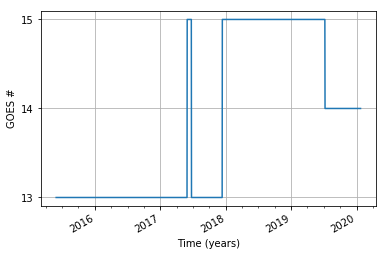

In [8]:
plot_cxctime(times, t['satellite'], color='C0')
plt.yticks([13, 14, 15], ["13", "14", "15"])
plt.xlabel("Time (years)")
plt.ylabel("GOES #")
plt.grid()

__Figure:__ GOES source changed from G-15 to G-14 in July 2019.

## July 2019 drop in the value of the GOES HRC shield rate proxy

In [9]:
# data files downloaded form ftp://ftp.swpc.noaa.gov/pub/lists/pchan/

f_2015 = '20150530_Gp_pchan_5m.txt'
dat_2015 = extract_p4_p5_p6_hrc_proxy(f_2015)
add_date_column(dat_2015)

f_before = '20190707_Gp_pchan_5m.txt'
dat_before = extract_p4_p5_p6_hrc_proxy(f_before)
add_date_column(dat_before)

f_after = '20190708_Gp_pchan_5m.txt'
dat_after = extract_p4_p5_p6_hrc_proxy(f_after)
add_date_column(dat_after)

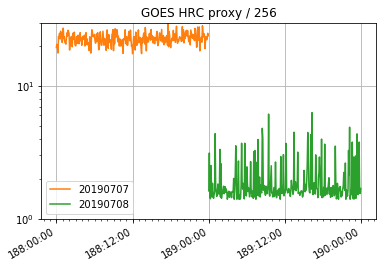

In [10]:
plot_hrc_proxy(dat_before, label=f_before[:8], color='C1')
plot_hrc_proxy(dat_after, label=f_after[:8], color='C2')
plt.legend(loc=3)
plt.yscale('log')
plt.grid()

__Figure:__ The drop in GOES HRC proxy happened on 2019-07-08. On that day the source changed from GOES-15 to GOES-14.

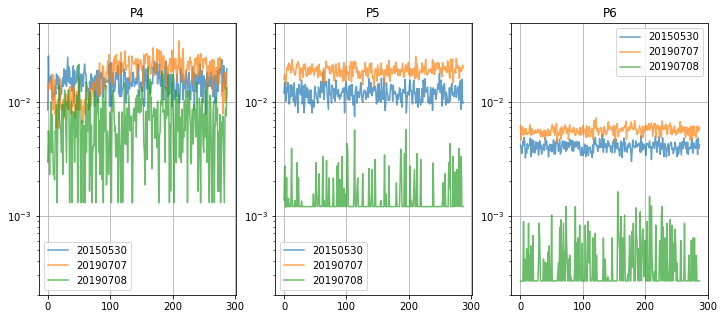

In [11]:
plot_p4_p5_p6([f_2015, f_before, f_after], [dat_2015, dat_before, dat_after])

__Figure:__ The drop in GOES HRC proxy is due to ~an order of mag drop in P5 and P6 fluxes, starting on 2019-07-08. On that date the source changed from GOES-15 to GOES-14.

## How to manipulate GOES-16 json files

In [12]:
# Using GOES-16, the most recent 1 day of data as of
DateTime().fits

'2020-01-29T04:39:12.026'

In [13]:
URL = 'https://services.swpc.noaa.gov/json/goes/primary/'

In [14]:
json_url = requests.get(f'{URL}/differential-protons-1-day.json')
data = json_url.json()

In [15]:
t = Table(data)

In [16]:
# flux per keV, not per MeV as before
t.colnames

['energy', 'flux', 'satellite', 'time_tag']

In [17]:
t[0]

energy,flux,satellite,time_tag
str17,float64,int64,str20
1020-1860 keV,3.60811827704e-05,16,2020-01-28T04:40:00Z


In [18]:
# Extract the lower and upper energy boundaries for each channel
# by manipulating the ``energy`` column and add ``e_lo`` and
# ``e_hi`` columns to the table
elos = []
ehis = []
for row in t['energy']:
    tmp = row.split(' ')
    items = tmp[0].split('-')
    elos.append(float(items[0]))
    ehis.append(float(items[1]))

In [19]:
t['e_lo'] = elos
t['e_hi'] = ehis

In [20]:
t.sort('time_tag')

In [21]:
t[:14]

energy,flux,satellite,time_tag,e_lo,e_hi
str17,float64,int64,str20,float64,float64
1020-1860 keV,3.60811827704e-05,16,2020-01-28T04:40:00Z,1020.0,1860.0
99900-118000 keV,1.87129330698e-06,16,2020-01-28T04:40:00Z,99900.0,118000.0
83700-98500 keV,1.30402452214e-06,16,2020-01-28T04:40:00Z,83700.0,98500.0
5840-11000 keV,4.11155888287e-05,16,2020-01-28T04:40:00Z,5840.0,11000.0
3400-6480 keV,0.0,16,2020-01-28T04:40:00Z,3400.0,6480.0
276000-404000 keV,2.25574865453e-07,16,2020-01-28T04:40:00Z,276000.0,404000.0
40300-73400 keV,2.51773144555e-06,16,2020-01-28T04:40:00Z,40300.0,73400.0
2310-3340 keV,5.88508446526e-05,16,2020-01-28T04:40:00Z,2310.0,3340.0
1900-2300 keV,0.0,16,2020-01-28T04:40:00Z,1900.0,2300.0


__Table:__ There are 13 energy channels in this file (differential proton flux). Channels corresponding to those used so far to compute the GOES HRC proxy are:
  * ``P4 * de_p4 ~ flux(11640-23270 keV) * de + flux(25900-38100 keV)* de``
  * ``P5 * de_p5 ~ flux(40300-73400 keV) * de``,
  * ``P6 * de_p6 ~ flux(83700-98500 keV) * de + flux(99900-118000 keV) * de + flux(115000-143000 keV) * de + flux(160000-242000 keV) * de``,
  
where ``de = e_hi - e_lo`` for a given channel, and ``de_p4``, ``de_p5``, and ``de_p6`` are defined below.

In [22]:
de_p4 = 23270 - 11640
de_p5 = 73400 - 40300
de_p6 = 242000 - 83700

In [23]:
p4_flux = 0
p5_flux = 0
p6_flux = 0
rows = []

time_tag = t['time_tag'][0]

for entry in t:
    if entry['time_tag'] != time_tag:

        p4_flux = p4_flux / de_p4
        p5_flux = p5_flux / de_p5
        p6_flux = p6_flux / de_p6
        
        # Save fluxes in ``per MeV``
        rows.append(['p4', p4_flux * 1000, 16, time_tag, 11.6, 23.27])
        rows.append(['p5', p5_flux * 1000, 16, time_tag, 40.3, 73.4])
        rows.append(['p6', p6_flux * 1000, 16, time_tag, 83.7, 242])

        # HRC proxy using fluxes converted from ``per keV`` to ``per MeV``
        hrc_proxy = calc_hrc_proxy(p4_flux * 1000, p5_flux * 1000, p6_flux * 1000)
        
        rows.append(['hrc_proxy', hrc_proxy, 16, time_tag, 11.6, 242])
        
        p4_flux = 0
        p5_flux = 0
        p6_flux = 0
        time_tag = entry['time_tag']
    
    energy = entry['energy']
    de = entry['e_hi'] - entry['e_lo']
    flux = entry['flux']
    
    if energy in ('11640-23270 keV', '25900-38100 keV'):
        p4_flux += flux * de
        
    if energy == '40300-73400 keV':
        p5_flux = flux * de
        
    if energy in ('83700-98500 keV', '99900-118000 keV',
                  '115000-143000 keV', '160000-242000 keV'):
        p6_flux += flux * de

In [24]:
for row in rows:
    t.add_row(row)

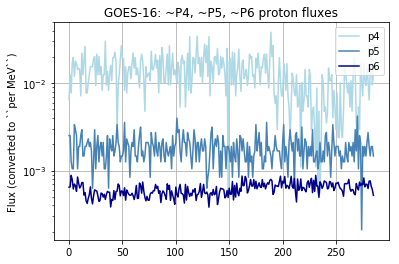

In [25]:
ok = t['energy'] == 'p4'
plt.plot(t['flux'][ok], 'lightblue', label='p4')

ok = t['energy'] == 'p5'
plt.plot(t['flux'][ok], 'steelblue', label='p5')

ok = t['energy'] == 'p6'
plt.plot(t['flux'][ok], 'darkblue', label='p6')

plt.legend()
plt.ylabel('Flux (converted to ``per MeV``)')
plt.title('GOES-16: ~P4, ~P5, ~P6 proton fluxes')
plt.yscale('log')
plt.grid()

__Figure:__ GOES-16 ~P5 and ~P6 fluxes are ~one order of mag lower than corresponding GOES-15 fluxes (before July 2019). The current understanding is that this is due to a higher sensitivity and lower noise level of GOES-16. In other words, in the quiet period we saw the noise level in these channels before and after July 2019, just that the noise level is different for different instruments. GOES-16 data at higher proton fluxes are needed in order to validate the HRC proxy formula.

In [26]:
t['time_tag'][0]

'2020-01-28T04:40:00Z'

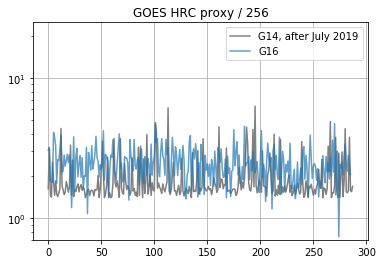

In [27]:
plt.plot(dat_after['hrc_proxy'] / 256, label='G14, after July 2019', color='gray')

ok = t['energy'] == 'hrc_proxy'
plt.plot(t['flux'][ok] / 256, label='G16', alpha=0.7)

plt.legend()
plt.title('GOES HRC proxy / 256')
plt.grid()
plt.ylim(7e-1, 25)
plt.yscale('log')

__Figure:__ G16 and G14 HRC proxies (after July 2019) are consistent with each other. The current understanding is that in all cases, G15, G14, G16, we see a noise level in this calculation, just at a different sensitivity level. Need high proton flux data to confirm that G14/G16 proxies would match the G15 proxy out of a quiet period.

## Periods of high HRC shield rate since 2018

In [28]:
dat = fetch.Msid('2shldart', '2017:100:00:00:00')

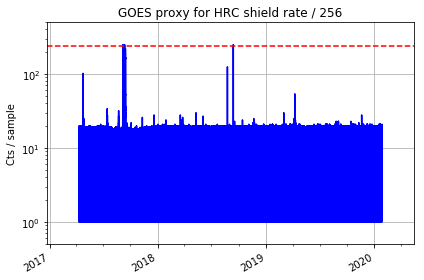

In [29]:
plot_hrc_shield(dat.times, dat.vals)

In [30]:
hi = dat.vals / 256 > 50

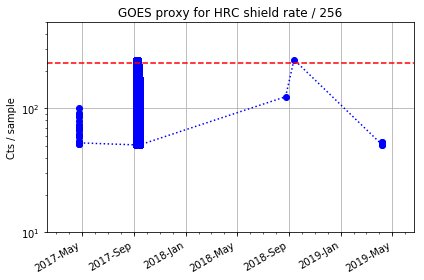

In [31]:
plot_hrc_shield(dat.times[hi], dat.vals[hi], marker='o', linestyle=':')

In [32]:
[DateTime(tt).date for tt in dat.times[hi][-20:]]

['2017:257:18:52:06.482',
 '2017:257:18:53:03.882',
 '2017:257:18:53:12.082',
 '2017:257:18:56:45.282',
 '2017:257:19:16:09.682',
 '2018:235:22:41:21.430',
 '2018:255:18:41:49.331',
 '2019:098:05:59:25.705',
 '2019:098:05:59:33.905',
 '2019:098:05:59:42.105',
 '2019:098:05:59:50.305',
 '2019:098:05:59:58.505',
 '2019:098:06:00:06.705',
 '2019:098:06:00:14.905',
 '2019:098:06:00:23.105',
 '2019:098:06:00:31.305',
 '2019:098:06:00:39.505',
 '2019:098:06:00:47.705',
 '2019:098:06:00:55.905',
 '2019:098:06:01:04.105']

__We need G-16 data from the high proton flux period of 2017 (not available according to Lina), 2018:235, 2018:255, 2019:098 to confirm that the HRC proxy formula is working with the G-16 data.__

## Confirm high P4, P5, P6 fluxes in periods of high HRC shield rate using archival GOES-15 data (2015-2020)

In [33]:
# This table contains 1-day averages for p4, p5, p6
t = Table.read('goes-2015-05-30-2020-01-22.dat', format='ascii')

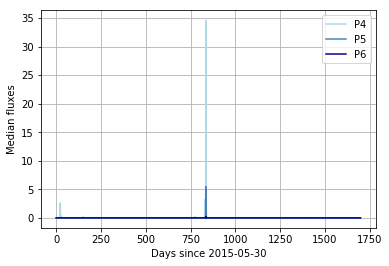

In [34]:
plt.plot(t['median_p4'], 'lightblue', label='P4')
plt.plot(t['median_p5'], 'steelblue', label='P5')
plt.plot(t['median_p6'], 'darkblue', label='P6')
plt.legend()
plt.xlabel("Days since 2015-05-30")
plt.ylabel("Median fluxes")
plt.grid()

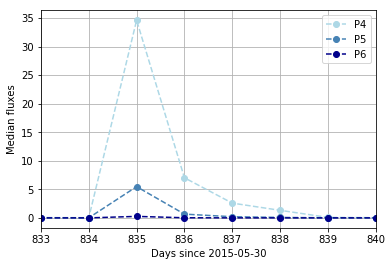

In [35]:
plt.plot(t['median_p4'], 'o--', color='lightblue', label='P4')
plt.plot(t['median_p5'], 'o--', color='steelblue', label='P5')
plt.plot(t['median_p6'], 'o--', color='darkblue', label='P6')
plt.legend()
plt.xlabel("Days since 2015-05-30")
plt.ylabel("Median fluxes")
plt.xlim(833, 840)
plt.grid()

__Figure:__ This corresponds to the 2017 high HRC shield rate event.

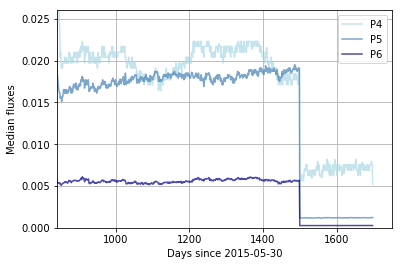

In [36]:
plt.plot(t['median_p4'], 'lightblue', label='P4', alpha=0.7)
plt.plot(t['median_p5'], 'steelblue', label='P5', alpha=0.7)
plt.plot(t['median_p6'], 'darkblue', label='P6', alpha=0.7)
plt.legend()
plt.xlabel("Days since 2015-05-30")
plt.ylabel("Median fluxes")
plt.xlim(840, 1750)
plt.ylim(0,0.026)
plt.grid()

__Figure:__ The 2018, 2019 high HRC shield rate events do not show here. However, I constructed this table so that it contains daily P4, P5, P6 averages. If the events were short they may not show here. Below I look for this event in archival 5m data.

In [37]:
# Date of the high HRC shield rate event in 2018
DateTime('2018:255:18:41:49.331').fits

'2018-09-12T18:42:58.515'

In [38]:
ftp = FTP("ftp.swpc.noaa.gov")
ftp.login()

ftp.cwd("/pub/lists/pchan/")
filename = "20180912_Gp_pchan_5m.txt"
local_filename = "tmp_protons.txt"
    
# retrieve the file
lf = open(local_filename, "wb")
ftp.retrbinary("RETR " + filename, lf.write, 16*1024)
lf.close()

dat = ascii.read(local_filename, data_start=2)
    
t = Table(dat, names=NAMES)
add_date_column(t)

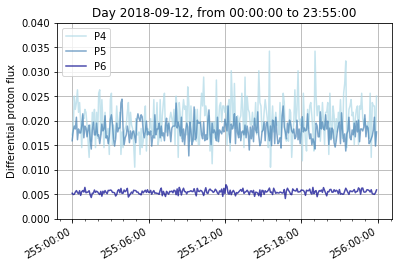

In [39]:
plot_cxctime(DateTime(t['date']).secs, t['P4'], 'lightblue', label='P4', alpha=0.7)
plot_cxctime(DateTime(t['date']).secs, t['P5'], 'steelblue', label='P5', alpha=0.7)
plot_cxctime(DateTime(t['date']).secs, t['P6'], 'darkblue', label='P6', alpha=0.7)
plt.legend()
plt.ylabel("Differential proton flux")
plt.ylim(0,0.04)
plt.title(f"Day {t['date'][0][:10]}, from {t['date'][0][11:-4]} to {t['date'][-1][11:-4]}")
plt.ylim(0, 0.04)
plt.grid()

In [40]:
hrc_proxy = calc_hrc_proxy(t['P4'], t['P5'], t['P6'])

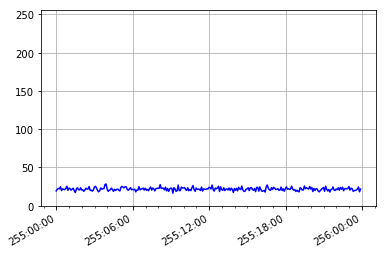

In [41]:
plot_cxctime(DateTime(t['date']).secs, hrc_proxy / 256)
plt.ylim(0, 256)
plt.grid()

__Figure:__ The high HRC shield rate event does not show up in the GOES data. Why?

## Level 1 and 2 archival GOES-16 data exploration

Cannot find appropriate archival GOES-16 data that would cover both the high energy band and time of the high HRC shield rate.

https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l1b/

https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/

In [42]:
from netCDF4 import Dataset

In [43]:
"""
Remote OPeNDAP-hosted datasets can be accessed for reading over http
if a URL is provided to the Dataset constructor instead of a filename.
However, this requires that the netCDF library be built with OPenDAP
support, via the --enable-dap configure option (added in version 4.0.1).
"""
URL_L1B = "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l1b/"
URL_L2 = "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/"

### Level 1

High energy data available, 80 to 500 MeV, but start on 2020-01.

In [44]:
# url = f"{URL_L1B}/seis-l1b-sgps/2020/01/ops_seis-l1b-sgps_g16_d20200101_v0-0-0.nc"
# url = f"/home/malgosia/git/wip/ops_seis-l1b-sgps_g16_d20200101_v0-0-0.nc"
url = f"/home/malgosia/git/wip/ops_seis-l1b-sgps_g16_d20200101_v0-0-0.nc"
nc = Dataset(url, "r", format="NETCDF4")

In [45]:
nc.variables.keys()

odict_keys(['T1_DifferentialProtonFluxes', 'T1_DifferentialProtonFluxUncertainties', 'T1_DifferentialProtonFluxDQFs', 'T2_DifferentialProtonFluxes', 'T2_DifferentialProtonFluxUncertainties', 'T2_DifferentialProtonFluxDQFs', 'T3_DifferentialProtonFluxes', 'T3_DifferentialProtonFluxUncertainties', 'T3_DifferentialProtonFluxDQFs', 'T3P11_IntegralProtonFlux', 'T3P11_IntegralProtonFluxUncertainties', 'T3P11_IntegralProtonFluxDQFs', 'L1a_EngData_Flag', 'L1a_SciData_Flag', 'L1b_Processing_Flag', 'N_blocks', 'Instrument_Mode', 'Instrument_Serial_Number', 'Diff31_Logic_Flags', 'L1a_SciData_TimeStamp', 'quaternion_Q0', 'quaternion_Q1', 'quaternion_Q2', 'quaternion_Q3', 'ECEF_X', 'ECEF_Y', 'ECEF_Z', 'yaw_flip_flag', 'eclipse_flag', 'solar_array_current', 'sgps_telemetry_time', 'sgps_sensor_temperature', 'product_time', 'sensor_unit_label', 'energy_T1_label', 'energy_T2_label', 'energy_T3_label', 'Diff31_logic_channel_label', 'solar_array_current_channel_index_label', 'percent_uncorrectable_L0_err

In [46]:
nc.variables['T3_DifferentialProtonFluxes']

<class 'netCDF4._netCDF4.Variable'>
float32 T3_DifferentialProtonFluxes(report_number, sensor_unit, energy_T3)
    _FillValue: -1e+31
    units: cm-2 sr-1 s-1 keV-1
    long_name: differential proton flux at specific energy bands for telescope 3's primary proton data channels on each of the two sensor units
    valid_range: [-9999999.  9999999.]
unlimited dimensions: report_number
current shape = (86399, 2, 5)
filling on

In [47]:
data = nc.variables['T3_DifferentialProtonFluxes'][:]

In [48]:
nc.variables['energy_T3_label']

<class 'netCDF4._netCDF4.Variable'>
|S1 energy_T3_label(energy_T3, energy_T3_str_len)
    long_name: labels for five energy bands reported from telescope 3 spanning from 80 to 500 MeV. labels are ordered the same as applicable data variables
unlimited dimensions: 
current shape = (5, 26)
filling on, default _FillValue of   used

In [49]:
labels = nc.variables['energy_T3_label'][:]

In [50]:
labels

masked_array(data =
 [[b'E' b'n' b'e' b'r' b'g' b'y' b'B' b'a' b'n' b'd' b'-' b'P' b'8' b'A'
  b'F' b':' b'8' b'3' b'-' b'9' b'9' b'M' b'e' b'V' -- --]
 [b'E' b'n' b'e' b'r' b'g' b'y' b'B' b'a' b'n' b'd' b'-' b'P' b'8' b'B'
  b'F' b':' b'9' b'9' b'-' b'1' b'1' b'8' b'M' b'e' b'V' --]
 [b'E' b'n' b'e' b'r' b'g' b'y' b'B' b'a' b'n' b'd' b'-' b'P' b'8' b'C'
  b'F' b':' b'1' b'1' b'8' b'-' b'1' b'5' b'0' b'M' b'e' b'V']
 [b'E' b'n' b'e' b'r' b'g' b'y' b'B' b'a' b'n' b'd' b'-' b'P' b'9' b'F'
  b':' b'1' b'5' b'0' b'-' b'2' b'7' b'5' b'M' b'e' b'V' --]
 [b'E' b'n' b'e' b'r' b'g' b'y' b'B' b'a' b'n' b'd' b'-' b'P' b'1' b'0'
  b':' b'2' b'7' b'5' b'-' b'5' b'0' b'0' b'M' b'e' b'V' --]],
             mask =
 [[False False False False False False False False False False False False
  False False False False False False False False False False False False
   True  True]
 [False False False False False False False False False False False False
  False False False False False False False False Fals

In [51]:
for d in labels.data:
    label = ('').join([dd.decode("utf-8") for dd in d])
    print(label)

EnergyBand-P8AF:83-99MeV
EnergyBand-P8BF:99-118MeV
EnergyBand-P8CF:118-150MeV
EnergyBand-P9F:150-275MeV
EnergyBand-P10:275-500MeV


### Level 2

A few years of data available, but only for a low energy band, from 80 keV to 12 MeV.

In [52]:
# url = "{URL_L2}/data/mpsh-l2-avg5m/2020/01/sci_mpsh-l2-avg5m_g16_d20200101_v1-0-2.nc"
url = "/home/malgosia/git/wip/sci_mpsh-l2-avg5m_g16_d20200101_v1-0-2.nc"
nc = Dataset(url,'r')

In [53]:
nc.variables.keys()

odict_keys(['L2_SciData_TimeStamp', 'L1bRecordsInAvg', 'YawFlipFlag', 'EclipseFlag', 'AvgDiffProtonFlux', 'AvgDiffProtonFluxUncert', 'DiffProtonValidL1bSamplesInAvg', 'DiffProtonDQFdtcSum', 'DiffProtonDQFoobSum', 'DiffProtonDQFerrSum', 'AvgDiffElectronFlux', 'AvgDiffElectronFluxUncert', 'DiffElectronEffectiveEnergy', 'DiffElectronValidL1bSamplesInAvg', 'DiffElectronDQFdtcSum', 'DiffElectronDQFoobSum', 'DiffElectronDQFerrSum', 'AvgIntElectronFlux', 'AvgIntElectronFluxUncert', 'IntElectronEffectiveEnergy', 'IntValidL1bSamplesInAvg', 'IntDQFdtcSum', 'IntDQFoobSum', 'IntDQFerrSum', 'DiffProtonLowerEnergy', 'DiffProtonUpperEnergy', 'DiffProtonEffectiveEnergy', 'ExpectedLUTNotFound'])

In [54]:
nc.variables['DiffProtonLowerEnergy']

<class 'netCDF4._netCDF4.Variable'>
float32 DiffProtonLowerEnergy(telescopes, proton_diff_chans)
    _FillValue: -9999.0
    long_name: Lower band energies for the MPS-HI proton differential channels P1-P11
    units: keV
    valid_min: 0.0
unlimited dimensions: 
current shape = (5, 11)
filling on

In [55]:
nc.variables['DiffProtonLowerEnergy'][:]

array([[   80.,   105.,   148.,   212.,   309.,   536.,   720.,  1000.,
         1900.,  3200.,  6500.],
       [   84.,   105.,   148.,   212.,   309.,   536.,   720.,  1000.,
         1900.,  3200.,  6500.],
       [   90.,   105.,   148.,   212.,   309.,   536.,   720.,  1000.,
         1900.,  3200.,  6500.],
       [   93.,   105.,   148.,   212.,   309.,   536.,   720.,  1000.,
         1900.,  3200.,  6500.],
       [   81.,   105.,   148.,   212.,   309.,   536.,   720.,  1000.,
         1900.,  3200.,  6500.]], dtype=float32)

In [56]:
nc.variables['DiffProtonUpperEnergy'][:]

array([[   119.,    148.,    212.,    309.,    536.,    720.,   1000.,
          1900.,   3200.,   6500.,  12000.],
       [   117.,    148.,    212.,    309.,    536.,    720.,   1000.,
          1900.,   3200.,   6500.,  12000.],
       [   130.,    148.,    212.,    309.,    536.,    720.,   1000.,
          1900.,   3200.,   6500.,  12000.],
       [   126.,    148.,    212.,    309.,    536.,    720.,   1000.,
          1900.,   3200.,   6500.,  12000.],
       [   114.,    148.,    212.,    309.,    536.,    720.,   1000.,
          1900.,   3200.,   6500.,  12000.]], dtype=float32)

In [57]:
nc.variables['DiffProtonUpperEnergy']

<class 'netCDF4._netCDF4.Variable'>
float32 DiffProtonUpperEnergy(telescopes, proton_diff_chans)
    _FillValue: -9999.0
    long_name: Upper band energies for the MPS-HI proton differential channels P1-P11
    units: keV
    valid_min: 0.0
unlimited dimensions: 
current shape = (5, 11)
filling on

In [58]:
nc.variables['AvgDiffProtonFlux']

<class 'netCDF4._netCDF4.Variable'>
float32 AvgDiffProtonFlux(record_number, telescopes, proton_diff_chans)
    _FillValue: -1e+31
    long_name: Time-averaged proton fluxes in several differential channels between 80 and 10,000 keV
    units: protons/(cm^2 sr keV s)
    valid_min: 0.0
    valid_max: 460000.0
unlimited dimensions: record_number
current shape = (288, 5, 11)
filling on